In [419]:
ac=[[461.5, 17.0], [422.5, 218.5], [438.5, 419.0], [334.5, 11.95], [30.5, 234.0], [126.5, 2.5]] 
x_values,y_values = np.array(ac)[:,0],np.array(ac)[:,1]
np.sqrt(np.diff(x_values)**2 + np.diff(y_values)**2),math.dist(ac[1],ac[2])
ac=ac[::-1]
x_values,y_values = np.array(ac)[:,0],np.array(ac)[:,1]
new_list = [sum(np.sqrt(np.diff(x_values)**2 + np.diff(y_values)**2)[:i]) for i in range(len(np.sqrt(np.diff(x_values)**2 + np.diff(y_values)**2)) + 1)]
new_list

[0,
 250.61574172425802,
 627.0758358909573,
 1047.201653355202,
 1248.3390442103089,
 1453.5785384603191]

PREVIOUS STUDENT'S CURVE FIT MODEL

In [421]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import sympy as sym
from itertools import product
coords=[[46.5, 18.0], [42.5, 18.5], [38.5, 19.0], [34.5, 19.5], [30.5, 20.0], [26.5, 20.5]] 
C = np.array([0.0011108741723468401, 0.0011823378868119714, 0.0012361214279843072, 0.0012658992872256142, 0.001283704410993905, 0.0012507918336789668])
v = np.array([-46.5, 42.5, 38.5, 34.5, 30.5, 26.5])
w = np.array([18.0, 18.5, 19.0, 19.5, 20.0, 20.5])
windspeed = np.zeros(np.size(v))+3
y = np.zeros(np.size(v))
stability =np.zeros(np.size(v))+4
x = v, w, y, windspeed, stability

def func(data, f, g, h, Q):
    v, w, y, windspeed, stability = data
    stability=stability[0]
    stability_values= {1 : (122.8,0.94470,24.1670,2.5334),
                2: (90.673, 0.93198, 18.3330, 1.8096),
                3: (61.141, 0.91465, 12.5, 1.0857),
                4: (34.459, 0.86974, 8.3330, 0.72382),
                5: (24.26, 0.83660, 6.25, 0.54287),
                6: (15.209, 0.81558, 4.1667, 0.36191)
                }
    P_a,P_b,P_c,P_d=(stability_values[stability][0]),(stability_values[stability][1]),(stability_values[stability][2]),(stability_values[stability][3])
    distance = np.sqrt((v - f)**2 + (w - g)**2)
    theta = 0.017453293 * (P_c - P_d * np.log(distance/1000))
    sigma_y = 465.11628 * (distance / 1000) * np.tan(theta)
    sigma_z = P_a * (distance / 1000)**P_b
    first_fracture = Q / (2 * np.pi * windspeed * sigma_y * sigma_z)
    exp_arg_z1 = -(-h)**2 / (2 * sigma_z**2)
    exp_arg_z2 = -(h)**2 / (2 * sigma_z**2)
    exp_arg_y = -(y)**2 / (2 * sigma_y**2)
    eq = first_fracture * (np.exp(exp_arg_z1) + np.exp(exp_arg_z2)) * np.exp(exp_arg_y)

    return eq

solution = [0, 0, 0, 0]
best_guess = 100000

for f, g, h, q in product(range(0,21), range(0,2), range(8), range(2)):
    p0 = [f, g, h, q]
    guess, _ = curve_fit(func, x, C, p0, maxfev=100000, method='dogbox')
    new_guess = sum(abs(p - opt) for p, opt in zip(p0, guess))
    if new_guess < best_guess:
        best_guess, solution = new_guess, guess

print('f =', solution[0], ',', 'g =', solution[1], ',', 'h =', solution[2], ',', 'Q =', solution[3])


f = 20.0 , g = 0.0 , h = 7.0 , Q = 1.7885869047439589


SYNTHETIC DATA GENERATION FOR LDA MODEL

In [422]:
from scipy.ndimage import rotate, shift
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
import scipy.stats as sp
import pandas as pd
import statsmodels.api as sm
import math
import cmath
import seaborn as sns
from sympy import symbols, solve, Eq

DataDict= {'Crosswind':[],'Distance On Centerline':[],'Negative Gradient':[],'Positive Gradient':[],'Stability Class':[]}

np.random.seed(42)
for Stability_Iteration in range(6,7):
    for Iteration in range(119):
        #INPUT FOR GAS PLUME
        #set from 1-6
        stability = Stability_Iteration                                                                                    
        #Origin Coordinates Of Plume
        angle= np.random.uniform(0, 2 * np.pi)
        stack_x = 0#np.random.uniform(0, 51) * np.cos(angle)
        stack_y = -50#np.random.uniform(0, 51) * np.sin(angle)
        stack_height = np.random.randint(1,11) 
        emission_rate = np.random.randint(10,21)                                                                 
        windspeed= np.random.randint(1,26)
        #Wind Angle In Degrees
        wind_direction= np.pi #np.random.uniform(0, 2*np.pi - 1e-5)

        #INPUT FOR ALGORITHM

        #GRID & STEPSIZE CALCULATION 

        x_range=np.arange(-100,101,0.5)
        y_range=np.arange(-100,101,0.5)
        z_range=np.arange(0,51,0.5)
        #It Turns Each Into 3D-Arrays For Calculations In All 3 Axis
        X,Y,Z = np.meshgrid(x_range,y_range,z_range)

        #WIND RELATED CALCULATIONS

        #For Future (height_slice_direction= math.atan2(measured_y - stack_y, measured_x - stack_x) *(180/(math.pi)))
        #3D-Arrays For Distance Between Coordinate & Origin
        x_origin=X-stack_x
        y_origin=Y-stack_y

        wind_xcomponent=windspeed*math.sin(wind_direction-np.pi)
        wind_ycomponent=windspeed*math.cos(wind_direction-np.pi)

        dot_product=wind_xcomponent*x_origin+wind_ycomponent*y_origin
        magnitudes= windspeed*((x_origin**2)+(y_origin**2))**0.5
        subtended=np.arccos(dot_product/(magnitudes))
        hypotenuse=((x_origin**2)+(y_origin**2))**0.5
        #Downwind Is X Of Gaussian Plume Formula 
        downwind=np.cos(subtended)*hypotenuse
        #Turns It Into Complex Format To Make Correct Calculations Later On.
        downwindimag=np.vectorize(complex)(downwind.real, downwind.imag)

        #PASQUILL CONSTANTS & SIGMA CALCULATION

        #Pasquill Constants Found In Resources
        stability_class= {1 : (122.8,0.94470,24.1670,2.5334),
                        2: (90.673, 0.93198, 18.3330, 1.8096),
                        3: (61.141, 0.91465, 12.5, 1.0857),
                        4: (34.459, 0.86974, 8.3330, 0.72382),
                        5: (24.26, 0.83660, 6.25, 0.54287),
                        6: (15.209, 0.81558, 4.1667, 0.36191)
                        }
        P_a=stability_class[stability][0] 
        P_b=stability_class[stability][1]
        P_c=stability_class[stability][2]
        P_d=stability_class[stability][3]
        sig_z = P_a*(abs((downwind/1000))**P_b)
        sig_z[sig_z > 5000] = 5000
        theta=0.017453293*(P_c-P_d*np.log((downwindimag/1000)))
        sig_y=(465.11628*downwind/1000)*np.tan(theta)

        #CROSSWIND AND GAUSSIAN FORMULA

        crosswind=np.sin(subtended)*hypotenuse
        indix,indiy,indiz=np.where((downwind > 0))
        Concentration= np.zeros(np.shape(downwind))
        Concentration[indix,indiy,indiz] =((emission_rate/(2*math.pi*windspeed*sig_y[indix,indiy,indiz]*sig_z[indix,indiy,indiz]))*(math.e**(-crosswind[indix,indiy,indiz]**2/(2*sig_y[indix,indiy,indiz]**2))* (math.e**(-(Z[indix,indiy,indiz]-stack_height)**2/(2*sig_z[indix,indiy,indiz]**2))+ math.e**(-(Z[indix,indiy,indiz]+stack_height)**2/(2*sig_z[indix,indiy,indiz]**2)))))
        #Prevents Issues Regarding Algorithm And Measurements
        Concentration2D=(Concentration[:,:, 0])
        Concentration[Concentration < 3e-5] = 0

        Concentration_At_MeasurementForX= []
        Concentration_At_MeasurementForY= []
        Measurement_Points=[] 
        Measurement_Points_Y=[]

        rand_sim_step2=np.random.uniform(-50,100)
        
        for i in range(-100+np.random.randint(0,10),101,5):
            Measurement_Points_Y.append([i,rand_sim_step2])
        for XYCoordinate in Measurement_Points_Y:
            Concentration_At_MeasurementForY.append(Concentration2D[(200+ round(XYCoordinate[1]*2)),(200+ round(XYCoordinate[0]*2))])
        while len(np.array(Concentration_At_MeasurementForY)[np.where(np.array(Concentration_At_MeasurementForY) > 0)]) < 2:
            rand_sim_step2=np.random.uniform(-50,100)
            Concentration_At_MeasurementForY=[]
            for i in range(-100+np.random.randint(0,10),101,5):
                Measurement_Points_Y.append([i,rand_sim_step2])
            for XYCoordinate in Measurement_Points_Y:
                Concentration_At_MeasurementForY.append(Concentration2D[(200+ round(XYCoordinate[1]*2)),(200+ round(XYCoordinate[0]*2))])
        Concentration_At_MeasurementForY=[]

        for i in range(-100,101,4):
            Measurement_Points.append([0,i])
        for i in range(-100+np.random.randint(0,10),101,5):
            Measurement_Points_Y.append([i,rand_sim_step2])
        Concentration_At_MeasurementForX=[]
        for XYCoordinate in Measurement_Points:
            Concentration_At_MeasurementForX.append(Concentration2D[(200+ round(XYCoordinate[1]*2)),(200+ round(XYCoordinate[0]*2))])

        for XYCoordinate in Measurement_Points_Y:
            Concentration_At_MeasurementForY.append(Concentration2D[(200+ round(XYCoordinate[1]*2)),(200+ round(XYCoordinate[0]*2))])
       
        max_c_ind=Concentration_At_MeasurementForX.index(max(Concentration_At_MeasurementForX))
        Crosswind=(np.array(Measurement_Points_Y)[np.where(np.array(Concentration_At_MeasurementForY) > 0)][-1]-np.array(Measurement_Points_Y)[np.where(np.array(Concentration_At_MeasurementForY) > 0)][0])[0]
        dist_cent=abs(Measurement_Points[max_c_ind][1]-rand_sim_step2)
        
        if max_c_ind+1 == len(Concentration_At_MeasurementForX):
            val=np.array(Concentration_At_MeasurementForX)[[max_c_ind-2,max_c_ind-1,max_c_ind]],[item[1] for item in np.array(Measurement_Points)[[max_c_ind-2,max_c_ind-1,max_c_ind]]]
            pos_grad,neg_grad=(val[0][1]-val[0][0])/(val[1][1]-val[1][0]),(val[0][2]-val[0][1])/(val[1][2]-val[1][1])
        elif max_c_ind+1 != len(Concentration_At_MeasurementForX):
            val=np.array(Concentration_At_MeasurementForX)[[max_c_ind-1,max_c_ind,max_c_ind+1]],[item[1] for item in np.array(Measurement_Points)[[max_c_ind-1,max_c_ind,max_c_ind+1]]]
            pos_grad,neg_grad=(val[0][1]-val[0][0])/(val[1][1]-val[1][0]),(val[0][2]-val[0][1])/(val[1][2]-val[1][1])
        else:
            print('error')
            print(max_c_ind,len(Measurement_Points),len(Concentration_At_MeasurementForX))
            break
        
        DataDict['Crosswind'].append(Crosswind)
        DataDict['Distance On Centerline'].append(dist_cent)
        DataDict['Negative Gradient'].append(neg_grad)
        DataDict['Positive Gradient'].append(pos_grad)
        DataDict['Stability Class'].append(Stability_Iteration)

C:\Users\danin\AppData\Local\Temp\ipykernel_11316\4269558857.py:55: RuntimeWarning: invalid value encountered in divide
  subtended=np.arccos(dot_product/(magnitudes))


KeyboardInterrupt: 

EXPIREMENTING WITH ROTATION

[0, -1] [0, 1] [0, 2]


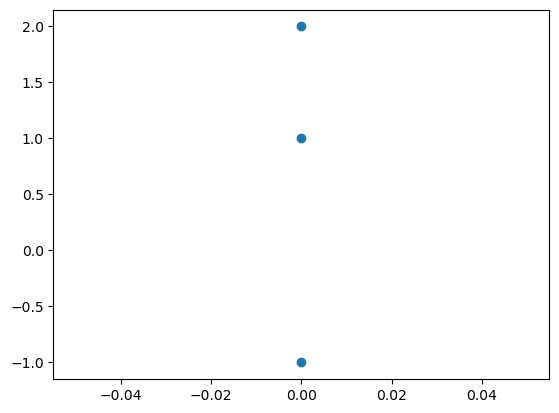

In [ ]:
theta=np.pi/3
a=np.array([[math.cos(theta), -math.sin(theta)],[math.sin(theta), math.cos(theta)]]) @ [0, -1]
b=np.array([[math.cos(theta), -math.sin(theta)],[math.sin(theta), math.cos(theta)]]) @[0,1]
c=np.array([[math.cos(theta), -math.sin(theta)],[math.sin(theta), math.cos(theta)]]) @ [0, 2]

theta=-np.pi/3
a=np.array([[math.cos(theta), -math.sin(theta)],[math.sin(theta), math.cos(theta)]]) @ a
b=np.array([[math.cos(theta), -math.sin(theta)],[math.sin(theta), math.cos(theta)]]) @b
c=np.array([[math.cos(theta), -math.sin(theta)],[math.sin(theta), math.cos(theta)]]) @ c

plt.scatter([round(a[0],2),round(b[0],2),round(c[0],2)],[round(a[1],2),round(b[1],2),round(c[1],2)])
print([0, -1],[0,1], [0, 2])

LDA MODELLING

In [27]:

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

plt.pcolor(x_range, y_range, Concentration2D, shading=None, cmap='jet')
len(Measurement_Points),len(Concentration_At_MeasurementForX)
Datadict1=pd.DataFrame(DataDict)
x_cols = ['Crosswind', 'Distance On Centerline', 'Negative Gradient','Positive Gradient']
model = LinearDiscriminantAnalysis(solver='lsqr').fit(Datadict1[x_cols], Datadict1['Stability Class'])
variables=pd.DataFrame([[2,2,2,2]], columns=x_cols)
result= model.predict(variables)
Datadict1.to_excel('Large_LDA_Data.xlsx')

NameError: name 'x_range' is not defined

In [ ]:
Crosswind=(np.array(Measurement_Points_Y)[np.where(np.array(Concentration_At_MeasurementForY) > 3e-5)][-1]-np.array(Measurement_Points_Y)[np.where(np.array(Concentration_At_MeasurementForY) > 3e-5)][0])[0]
abs(Measurement_Points[Concentration_At_MeasurementForX.index(max(Concentration_At_MeasurementForX))][1]-rand_sim_step2)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA_Data=pd.read_excel('LDA_Data.xlsx')
x_cols = ['Crosswind', 'Distance On Centerline', 'Negative Gradient','Positive Gradient']
model = LinearDiscriminantAnalysis(solver='lsqr').fit(LDA_Data[x_cols], LDA_Data['Stability Class'])
variables=pd.DataFrame([[2,2,2,2]], columns=x_cols)
result= model.predict(variables)

WEIBULL FITTING

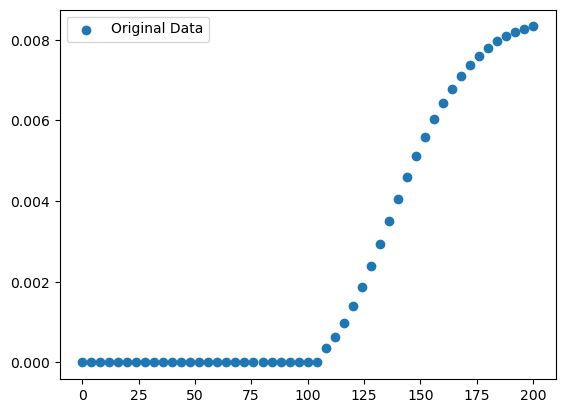

Fitted Weibull Parameter:
Scale parameter (lambda): 252.44996040377023


,Crosswind,Distance On Centerline,Negative Gradient,Positive Gradient,Stability Class
0,106.0,28.874913,3.033889e-05,0.000088,1
1,171.0,70.299816,8.596018e-05,0.000250,1
2,122.0,69.747974,1.285196e-04,0.000336,1
3,104.0,27.135166,2.505811e-06,0.000012,1
4,178.0,107.330263,2.423083e-05,0.000098,1
...,...,...,...,...,...
603,43.0,45.288213,3.132505e-07,0.000002,4
604,25.0,33.856643,3.299204e-07,0.000005,4
605,22.0,65.817763,4.072044e-06,0.000010,4
606,15.0,16.268471,8.769621e-02,0.060777,4


In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Your data
x = np.array([item[1] for item in Measurement_Points]) + 100
y = np.array(Concentration_At_MeasurementForX) * 10

k = 2  # Shape parameter known

# Define the Weibull PDF function
def weibull_pdf(x, scale):
    if isinstance(x, (int, float)):
        x = np.array([x])
    
    y = (k / scale) * (x / scale)**(k - 1) * np.exp(-(x / scale)**k)
    
    return y
# Fit the Weibull distribution to the PDF of the data
params, covariance = curve_fit(weibull_pdf, x, y, p0=[111])  # Initial guess for the scale parameter

# Extract the fitted parameters
scale = params[0]

# Plot the original data
plt.scatter(x, y, label='Original Data')

# Plot the fitted Weibull distribution PDF
x_fit = np.linspace(min(x), max(x), 1000)
y_fit = weibull_pdf(x_fit, scale)
#plt.plot(x_fit, y_fit, label='Fitted Weibull Distribution PDF', color='red')

plt.legend()
plt.show()

print("Fitted Weibull Parameter:")
print(f"Scale parameter (lambda): {scale}")

CURVE-FIT BY ITSELF

C:\Users\danin\AppData\Local\Temp\ipykernel_22116\2807810455.py:30: RuntimeWarning: divide by zero encountered in log
  theta = np.radians(c - d * np.log(x / 1000))
C:\Users\danin\AppData\Local\Temp\ipykernel_22116\2807810455.py:31: RuntimeWarning: invalid value encountered in tan
  sy = 465.11628 * (x / 1000) * np.tan(theta)
C:\Users\danin\AppData\Local\Temp\ipykernel_22116\2807810455.py:35: RuntimeWarning: divide by zero encountered in divide
  np.exp(- (z_or - h) ** 2 / (2 * sz ** 2)) +
C:\Users\danin\AppData\Local\Temp\ipykernel_22116\2807810455.py:36: RuntimeWarning: divide by zero encountered in divide
  np.exp(- (z_or + h) ** 2 / (2 * sz ** 2))


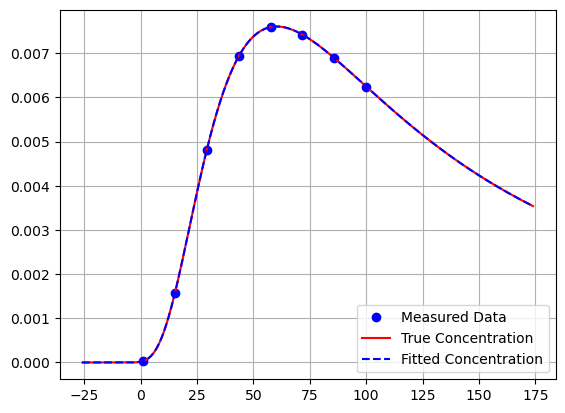

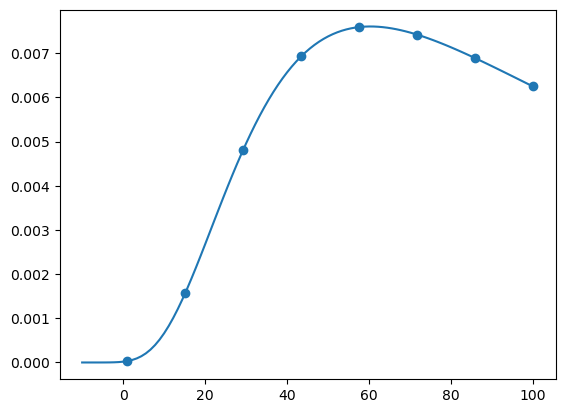

Fitted Parameters: [ 10.00032306 -26.00101331  13.0002225 ]


0.0007266452951534658

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

stability=2

stability_values= {1 : (122.8,0.94470,24.1670,2.5334),
                2: (90.673, 0.93198, 18.3330, 1.8096),
                3: (61.141, 0.91465, 12.5, 1.0857),
                4: (34.459, 0.86974, 8.3330, 0.72382),
                5: (24.26, 0.83660, 6.25, 0.54287),
                6: (15.209, 0.81558, 4.1667, 0.36191)
                }
P_a,P_b,P_c,P_d=(stability_values[stability][0]),(stability_values[stability][1]),(stability_values[stability][2]),(stability_values[stability][3])


def cGP(x_or, Qu, x_leak, h):
    y_or = 0
    y_leak = 0
    z_or = 0
    
    x = x_or - x_leak
    y = y_or - y_leak

    a = P_a
    b = P_b
    c = P_c
    d = P_d

    theta = np.radians(c - d * np.log(x / 1000))
    sy = 465.11628 * (x / 1000) * np.tan(theta)
    sz = np.minimum(a * (x / 1000) ** b, 5000)

    c = (Qu / (2 * np.pi * sy * sz)) * (
            np.exp(- (z_or - h) ** 2 / (2 * sz ** 2)) +
            np.exp(- (z_or + h) ** 2 / (2 * sz ** 2))
    ) * np.exp(-y ** 2 / (2 * sy ** 2))

    return c

# Synthetic data generation
xMeas = np.linspace(1, 100, 8)
b = np.array([10, -26, 13])
cEx = cGP(xMeas, *b)

rPert = 0.0
np.random.seed(15)
cPert = rPert * cEx * np.random.randn(len(cEx))
cMeas = cEx + cPert

# Plotting
plt.plot(xMeas, cMeas, 'bo', label='Measured Data')
xPlot = np.linspace(b[1], b[1] + 200, 1200)
plt.plot(xPlot, cGP(xPlot, *b), 'r', label='True Concentration')
plt.grid(True)

# Optimization using curve_fit
beta0 = [3.0, 0.3, 0.5]
bounds=([0,-200,1],[21,0,21])
beta_fit, covariance_matrix = curve_fit(cGP, xMeas, cMeas, method='trf',bounds=bounds,maxfev=100000)
std_errors = np.sqrt(np.diag(covariance_matrix))
# Plotting the fitted curve
plt.plot(xPlot, cGP(xPlot, *beta_fit), 'b--', label='Fitted Concentration')
plt.legend()
plt.show()
XPLOT=np.linspace(-10,100,100)
plt.plot(XPLOT,cGP(XPLOT,*beta_fit))
plt.scatter(xMeas,cMeas)
plt.show()
print("Fitted Parameters:", beta_fit)
sum(std_errors)